# Friends Classification Text (LSTM) - 6

This is classification of dialogue in FRIENDS TV Series.

<!-- https://stackoverflow.com/questions/61000500/tensorflow-keras-bert-multiclass-text-classification-accuracy -->

In [57]:
import pandas as pd
import re
import numpy as np
import time

import os
import pprint
import tensorflow as tf

import sys
sys.path.insert(1, '../../src/all_functions/')

from text_tools import *

import keras
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.models import load_model

from keras.layers import Embedding, LSTM
import matplotlib.pyplot as plt
from keras import Sequential

from keras import backend as K
from keras import layers

from sklearn.preprocessing import OneHotEncoder


from sklearn.metrics import (classification_report,
                             confusion_matrix,
                             roc_auc_score)

import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# from google.colab import drive
# drive.mount('/content/gdrive')

In [2]:
# help(drive.mount)

In [3]:
def encode(text):
    token_ids = []
    for word in text:
        try:
            token_ids.append(word2idx[word])
        except:
            token_ids.append(1)
            
    token_ids = np.array(token_ids)
    return token_ids

def set_fix_length(ids, max_len = 15):
    # print(ids)
    length = ids.shape[0]
    zeros = np.zeros(max_len)

    if length <= max_len:
        zeros[:length] = ids
    else:
        zeros = ids[:max_len]

    return zeros

In [4]:
# PATH_DATA = 'gdrive/'
PATH_DATA = '../../data/'

In [5]:
os.listdir(PATH_DATA)

['friends_seen_season_new.csv',
 'friends_unseen_season.csv',
 'friends-transcripts',
 'friends_all_dialogue.csv',
 '.DS_Store',
 'friends_all_dialogue_semi_cln.csv',
 'friends_unseen_season2_2.csv',
 'friends_unseen_season_1.csv',
 'friends_seen_season2_2.csv',
 'friends-transcripts-extract',
 'friends_seen_season2_new.csv',
 'friends_unseen_season_new.csv',
 'friends_seen_season.csv',
 'friends_all_dialogue_semi_cln2.csv',
 'friends_unseen_season2_new.csv',
 '.ipynb_checkpoints',
 'friends_seen_season2.csv',
 'friends_unseen_season2.csv',
 'friends_seen_season_1.csv']

## Importing Data

In [6]:
# %cd gdrive/My Drive/Repository/Data/

In [7]:
# os.listdir()

In [8]:
# df_dlg_seen = pd.read_csv(PATH_DATA+'friends_seen_season2.csv')
# df_dlg_unseen = pd.read_csv(PATH_DATA+'friends_unseen_season2.csv')

df_dlg_seen = pd.read_csv(PATH_DATA+'friends_seen_season2_2.csv')
df_dlg_unseen = pd.read_csv(PATH_DATA+'friends_unseen_season2_2.csv')

/Users/alamhanz/anaconda/envs/joko/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [9]:
df_dlg_seen.rename(columns = {'label_place':'places'},inplace=True)
df_dlg_unseen.rename(columns = {'label_place':'places'},inplace=True)

In [10]:
df_dlg_seen.head()

,eps,dialogue_ids,scenes_places,places,label_str,label,season,dialogue,text2,len_dialogue5,is_null2,ids,is_train,text1,label_prev,label_str_prev,is_null2_prev
0,0101,1,[central perk],1,joey,5,1,"c'mon, you're going out with the guy! there'...",c'mon you're going out with the guy there's go...,14,False,1,False,there's nothing to tell he's just some guy i w...,3.0,monica,False
1,0101,2,[central perk],1,chandler,4,1,"all right joey, be nice. so does he have a...",all right joey be nice so does he have a hump ...,16,False,2,True,c'mon you're going out with the guy there's go...,5.0,joey,False
2,0101,3,[central perk],1,phoebe,6,1,"wait, does he eat chalk? (they all stare, be...",wait does he eat chalk,5,False,3,False,all right joey be nice so does he have a hump ...,4.0,chandler,False
3,0101,5,[central perk],1,monica,3,1,"okay, everybody relax. this is not even a da...",okay everybody relax this is not even a date i...,21,False,5,True,just because i don't want her to go through wh...,6.0,phoebe,False
4,0101,6,[central perk],1,chandler,4,1,sounds like a date to me. [time lapse],sounds like a date to me,6,False,6,True,okay everybody relax this is not even a date i...,3.0,monica,False


In [11]:
df_dlg_seen.label.unique()

array([5, 4, 6, 3, 0, 2, 1])

In [12]:
df_dlg_seen_1 = df_dlg_seen[df_dlg_seen.season.isin([4,5,6,7,8])]
df_dlg_seen_2 = df_dlg_seen[df_dlg_seen.season.isin([2,3])&df_dlg_seen.label.isin([5,6])]
df_dlg_seen = pd.concat([df_dlg_seen_1,df_dlg_seen_2])

In [13]:
data_train = df_dlg_seen[(df_dlg_seen.is_train == True)&(df_dlg_seen.label!=0)][['text1','text2','label_prev','places','season','label']]
data_train['label'] = data_train['label']-1
data_train = data_train[~(data_train.text1.isnull())]

data_test = df_dlg_seen[(df_dlg_seen.is_train == False)&(df_dlg_seen.label!=0)][['text1','text2','label_prev','places','season','label']]
data_test['label'] = data_test['label']-1
data_test = data_test[~(data_test.text1.isnull())]

data_unseen = df_dlg_unseen[(df_dlg_unseen.label!=0)][['text1','text2','label_prev','places','season','label']]
data_unseen['label'] = data_unseen['label']-1
data_unseen = data_unseen[~(data_unseen.text1.isnull())]

In [14]:
data_train.shape

(18464, 6)

In [15]:
data_test.shape

(6139, 6)

In [16]:
data_unseen.shape

(8305, 6)

In [17]:
XX = data_train.label.value_counts()
XX/XX.sum()

4    0.201690
5    0.179864
0    0.169736
3    0.151213
2    0.149643
1    0.147855
Name: label, dtype: float64

In [18]:
XX = data_unseen.label.value_counts()
XX/XX.sum()

1    0.180253
0    0.169777
3    0.168694
2    0.164840
4    0.163757
5    0.152679
Name: label, dtype: float64

## Tokenizer

In [19]:
MAX_LEN = 20
EMBED_SIZE = 128

In [20]:
OH = OneHotEncoder()
OH_people = OneHotEncoder()
OH_place = OneHotEncoder()

In [21]:
data_train.head()

,text1,text2,label_prev,places,season,label
15219,ehh,oh and then monica joked that she wouldn't go ...,6.0,0,4,4
15220,oh and then monica joked that she wouldn't go ...,there,5.0,0,4,3
15221,there,and he couldn't let it go and i don't really k...,4.0,0,4,4
15224,a million,oh you're welcome a million,0.0,0,4,0
15226,my god,i,1.0,0,4,1


In [22]:
data_test.head()

,text1,text2,label_prev,places,season,label
15218,i'm your mother,ehh,0.0,0,4,5
15222,rachel was just helping me out my head got all...,awww,0.0,0,4,1
15233,no she likes that yeah faking sleep doesn't wo...,whoa ho,2.0,0,4,0
15235,whoa oh okay yeah why am i telling you that,i don't,2.0,0,4,0
15248,well any how some how i got pregnant and and i...,yeah let's see my had mom killed herself and m...,0.0,0,4,5


In [23]:
data_unseen.head()

,text1,text2,label_prev,places,season,label
0,so uh i guess we should make it official huh,uh look rach hey ross is here hey look it's my...,1.0,2,9,4
1,uh look rach hey ross is here hey look it's my...,joey you,5.0,2,9,1
2,joey you,you,2.0,2,9,0
3,you,hey and look he brought flowers thanks ross bu...,1.0,2,9,4
4,hey and look he brought flowers thanks ross bu...,you're weird today listen i uh wanted to talk ...,5.0,2,9,1


In [24]:
get_ids = pd.concat([data_train,data_test])
get_ids = pd.DataFrame(get_ids['text1'].tolist()+get_ids['text2'].tolist(),columns = ['text'])

In [25]:
word2idx, idx2word = data_text_prep(get_ids)

In [26]:
VOCAB_SIZE = len(word2idx)
VOCAB_SIZE

10901

In [27]:
get_ids = pd.concat([data_train,data_test])
OH.fit(get_ids['label'].values.reshape(len(get_ids),-1))
OH_people.fit(get_ids['label_prev'].values.reshape(len(get_ids),-1))
OH_place.fit(get_ids['places'].values.reshape(len(get_ids),-1))

OneHotEncoder()

In [28]:
def get_input(df):
    X1 = []
    X2 = []
    f1 = []
    f2 = []
    f3 = []
    
    label_ls = []
    for txt1,txt2,label1,label2,label3,label in df.values:
        text_encode = encode(txt1)
        text_encode = set_fix_length(text_encode,max_len=MAX_LEN)
        X1.append(text_encode)
        
        text_encode = encode(txt2)
        text_encode = set_fix_length(text_encode,max_len=MAX_LEN)
        X2.append(text_encode)
        
        f1.append(int(label1))
        f2.append(int(label2))
        label_ls.append(label)
    
    Xf1 = OH_people.transform(np.array(f1).reshape(len(f1),-1)).toarray()
    Xf2 = OH_place.transform(np.array(f2).reshape(len(f1),-1)).toarray()
    
    X3 = np.concatenate([Xf1,Xf2],axis = 1)
    
    return np.stack(X1),np.stack(X2),np.array(X3),np.array(label_ls)

In [29]:
X_train1,X_train2,X_train3,label_train = get_input(data_train)
X_test1,X_test2,X_test3,label_test = get_input(data_test)
X_unseen1,X_unseen2,X_unseen3,label_unseen = get_input(data_unseen)

In [30]:
X_train1.shape,X_train2.shape,X_train3.shape

((18464, 20), (18464, 20), (18464, 20))

In [31]:
X_unseen1.shape,X_unseen2.shape,X_unseen3.shape

((8305, 20), (8305, 20), (8305, 20))

In [32]:
y_train = OH.transform(label_train.reshape(len(label_train),-1)).toarray()
y_test = OH.transform(label_test.reshape(len(label_test),-1)).toarray()
y_unseen = OH.transform(label_unseen.reshape(len(label_unseen),-1)).toarray()

In [33]:
X_train3.shape

(18464, 20)

## Training Model

In [41]:
def text_net() :
    # sentence_indices = keras.Input(25, dtype = 'int32')
    mod1 = Sequential()
    mod1.add(Embedding(VOCAB_SIZE, EMBED_SIZE))
    mod1.add(LSTM(128,return_sequences = True))
    mod1.add(LSTM(64,return_sequences = True))
    mod1.add(layers.Dropout(0.4))
    return mod1

In [42]:
input_dim_txt = (MAX_LEN)
txt_1 = keras.Input(shape=input_dim_txt)
txt_2 = keras.Input(shape=input_dim_txt)
inp_3 = keras.Input(shape=(20))

In [43]:
tx_net = text_net()
connect_layer = layers.Concatenate(axis=2)
connect_layer2 = layers.Concatenate(axis=1)

feat_txt_1 = tx_net(txt_1)
feat_txt_2 = tx_net(txt_2)

concat_txt = connect_layer([feat_txt_1, feat_txt_2])
inp_3_emb = layers.Dense(128,activation='relu')(inp_3)
inp_3_emb = layers.Dense(128,activation='relu')(inp_3_emb)
inp_3_emb = layers.Dense(64,activation='relu')(inp_3_emb)
inp_3_emb = layers.Dense(16,activation='relu')(inp_3_emb)

LSTM_2 = LSTM(64,return_sequences = True)(concat_txt)
LSTM_2 = LSTM(16,return_sequences = True)(LSTM_2)
layers_n = layers.Flatten()(LSTM_2)
layers_n = layers.Dense(256,activation='relu')(layers_n)
layers_n = layers.Dropout(0.2)(layers_n)
layers_n = layers.Dense(16,activation='relu')(layers_n)
layers_n = connect_layer2([layers_n, inp_3_emb])

layers_n = layers.Dense(32,activation='relu')(layers_n)
layers_n = layers.Dense(32,activation='relu')(layers_n)
layers_n = layers.Dropout(0.2)(layers_n)
prediction = layers.Dense(6,activation='softmax')(layers_n)

mod1 = keras.Model(inputs = [txt_1, txt_2, inp_3], outputs = prediction)

In [44]:
mod1.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, None, 64)     1576320     input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 20, 128)      0           sequential_1[0][0]    

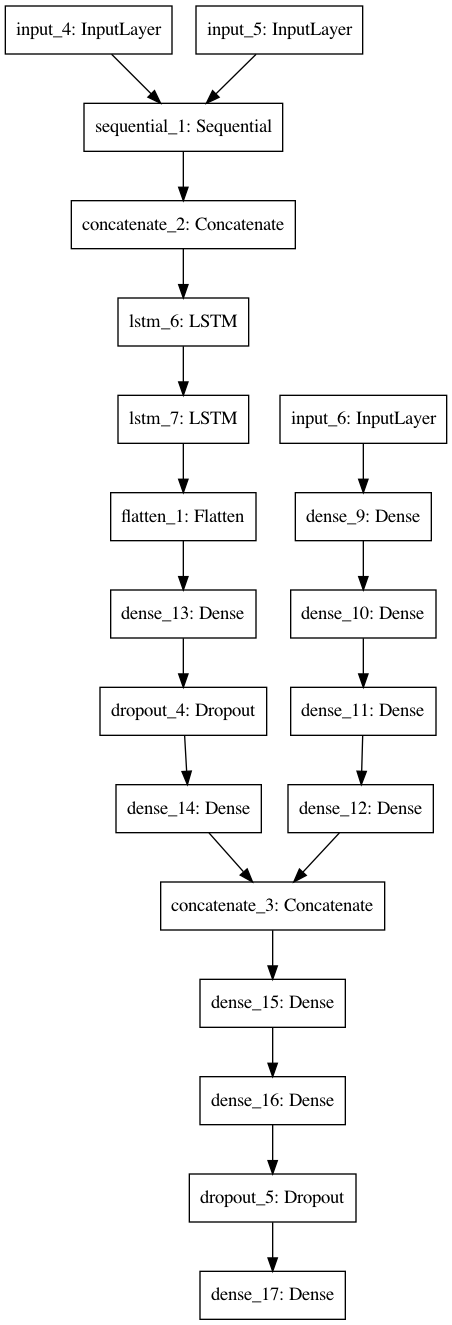

In [45]:
keras.utils.plot_model(mod1)

In [46]:
filepath = '../../models/simple_LSTM7/model_{epoch:02d}_{val_accuracy:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True)

In [47]:
# recommended learning rate for Adam 5e-5, 3e-5, 2e-5
LR = 5e-4
EPOCHS = 50
BATCH_SIZE = 25
opt = keras.optimizers.Adam(learning_rate=LR)
mod1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

mod_history = mod1.fit([X_train1,X_train2,X_train3], y_train, 
            validation_data=([X_test1,X_test2,X_test3], y_test), 
            epochs=EPOCHS, batch_size = BATCH_SIZE, verbose=1,
            callbacks=[checkpoint])

Epoch 1/50
739/739 [==============================] - ETA: 0s - loss: 1.6438 - accuracy: 0.3068
Epoch 00001: val_accuracy improved from -inf to 0.33979, saving model to ../../models/simple_LSTM7/model_01_0.34.hdf5
739/739 [==============================] - 90s 121ms/step - loss: 1.6438 - accuracy: 0.3068 - val_loss: 1.5550 - val_accuracy: 0.3398
Epoch 2/50
739/739 [==============================] - ETA: 0s - loss: 1.5593 - accuracy: 0.3388
Epoch 00002: val_accuracy improved from 0.33979 to 0.35918, saving model to ../../models/simple_LSTM7/model_02_0.36.hdf5
739/739 [==============================] - 61s 82ms/step - loss: 1.5593 - accuracy: 0.3388 - val_loss: 1.5169 - val_accuracy: 0.3592
Epoch 3/50
739/739 [==============================] - ETA: 0s - loss: 1.5254 - accuracy: 0.3532
Epoch 00003: val_accuracy improved from 0.35918 to 0.38752, saving model to ../../models/simple_LSTM7/model_03_0.39.hdf5
739/739 [==============================] - 62s 84ms/step - loss: 1.5254 - accuracy: 0

## Testing

In [56]:
mod_use1 = keras.models.load_model('../../models/simple_LSTM7/model_21_0.41.hdf5')
# mod_use2 = keras.models.load_model('../../models/simple_LSTM4/model_27_0.40.hdf5')

In [58]:
y_pred1 = mod_use1.predict([X_unseen1,X_unseen2,X_unseen3])
# y_pred2 = mod_use2.predict([X_unseen1,X_unseen2,X_unseen3])
y_pred2 = joblib.load('../../models/simple_LSTM4/y_pred4.pkl')

In [55]:
y_pred1.shape

(8305, 6)

In [59]:
y_pred2.shape

(8305, 6)

In [129]:
yP1 = np.maximum(y_pred1,y_pred2)
yP2 = (y_pred1+y_pred2)/2


w1 = 0.5
w2 = 1-w1
yP3 = (w1*(y_pred1[:,:4]))+(w2*(y_pred2[:,:4]))
yP3 = np.concatenate([yP3,y_pred1[:,4:]],axis = 1)

In [90]:
def plot_cm(labels, predictions, p=0.5):
#     cm = confusion_matrix(labels, predictions)
#     plt.figure(figsize=(5, 5))
#     sns.heatmap(cm, annot=True, fmt="d")
    cm = confusion_matrix(labels, predictions)
    cm = (cm.transpose()/cm.sum(axis = 1)).transpose()
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt=".2%")
    plt.title("Confusion matrix (non-normalized))")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")

### 1

In [91]:
y_pred_label = np.argmax(y_pred1,axis = 1)
y_true_label = data_unseen['label'].values

              precision    recall  f1-score   support

           0       0.39      0.33      0.36      1410
           1       0.40      0.24      0.30      1497
           2       0.43      0.41      0.42      1369
           3       0.44      0.48      0.46      1401
           4       0.34      0.40      0.37      1360
           5       0.29      0.41      0.34      1268

    accuracy                           0.38      8305
   macro avg       0.38      0.38      0.38      8305
weighted avg       0.38      0.38      0.37      8305



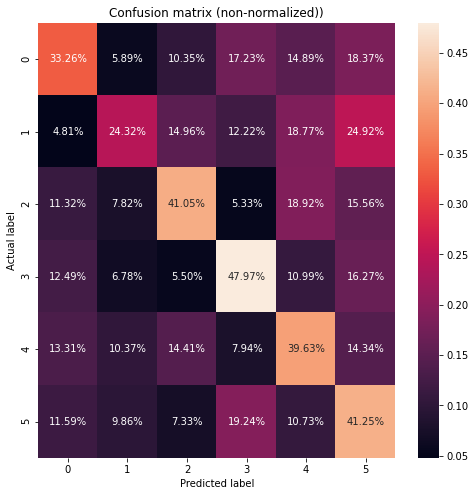

In [92]:
report = classification_report(y_true_label, y_pred_label)
print(report)
plot_cm(y_true_label, y_pred_label)

### 2

In [93]:
y_pred_label = np.argmax(yP1,axis = 1)
y_true_label = data_unseen['label'].values

              precision    recall  f1-score   support

           0       0.36      0.36      0.36      1410
           1       0.35      0.36      0.35      1497
           2       0.43      0.45      0.44      1369
           3       0.44      0.48      0.46      1401
           4       0.39      0.34      0.36      1360
           5       0.33      0.31      0.32      1268

    accuracy                           0.38      8305
   macro avg       0.38      0.38      0.38      8305
weighted avg       0.38      0.38      0.38      8305



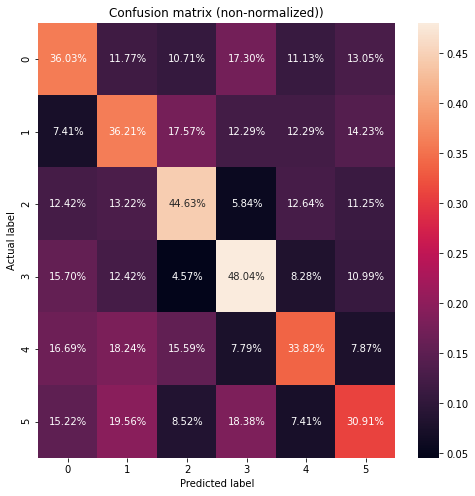

In [94]:
report = classification_report(y_true_label, y_pred_label)
print(report)
plot_cm(y_true_label, y_pred_label)

### 3

In [95]:
y_pred_label = np.argmax(yP2,axis = 1)
y_true_label = data_unseen['label'].values

              precision    recall  f1-score   support

           0       0.35      0.37      0.36      1410
           1       0.35      0.38      0.36      1497
           2       0.43      0.46      0.44      1369
           3       0.43      0.50      0.46      1401
           4       0.41      0.31      0.35      1360
           5       0.34      0.30      0.32      1268

    accuracy                           0.39      8305
   macro avg       0.39      0.39      0.38      8305
weighted avg       0.39      0.39      0.38      8305



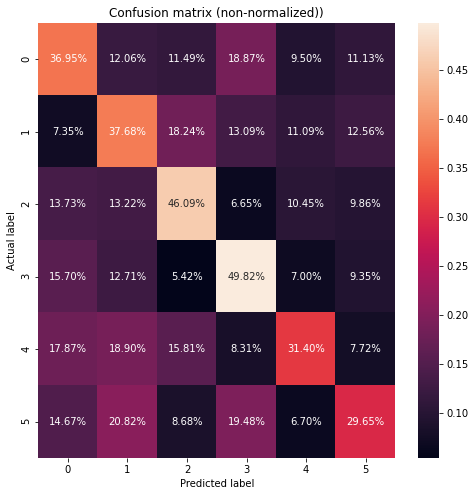

In [96]:
report = classification_report(y_true_label, y_pred_label)
print(report)
plot_cm(y_true_label, y_pred_label)

### 4

In [130]:
y_pred_label = np.argmax(yP3,axis = 1)
y_true_label = data_unseen['label'].values

              precision    recall  f1-score   support

           0       0.38      0.34      0.36      1410
           1       0.37      0.31      0.34      1497
           2       0.45      0.43      0.44      1369
           3       0.46      0.48      0.47      1401
           4       0.35      0.37      0.36      1360
           5       0.30      0.38      0.33      1268

    accuracy                           0.38      8305
   macro avg       0.38      0.38      0.38      8305
weighted avg       0.39      0.38      0.38      8305



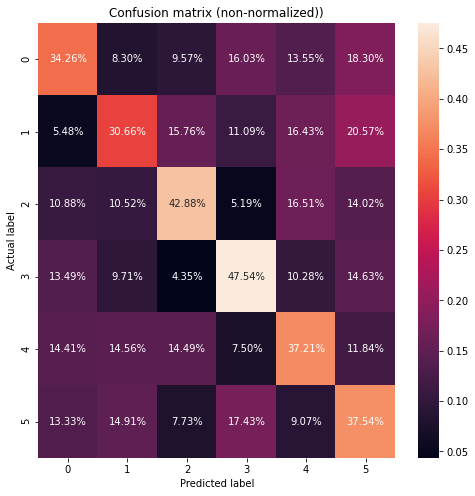

In [131]:
report = classification_report(y_true_label, y_pred_label)
print(report)
plot_cm(y_true_label, y_pred_label)